<img src='spotify_pic.jpg'>
<center><b><h1>Predicting <i>Billboard</i> Hot 100 Ranking Using Spotify's API</h1></b></center>
<center><b><h3>Created by Matthew Shein and Ravi Ramanathan</h3></b></center>
<h1>Introduction</h1>

The <i>Billboard</i> Hot 100 is a weekly record chart published weekly by <i>Billboard</i> magazine for music in the United States. At the end of every year, <i>Billboard</i> releases a Hot 100 for the most popular music in the United States over that year. For this project, we decided to use previous year's Hot 100 lists to see if we could accurately predict the rankings of songs for 2019.

Highly popular songs are those that are catchy, compelling, and well crafted. It must connect to a broader audience and elicit some kind of action from the listener: tears, laughter, dancing. Not only does the song have to be catchy and cause the audience to react, it has to be promoted properly through a promotion team and/or social media. If a promotion team is forced or coerced into promoting a song, it's unlikely that it will reach the top of the charts. The more enthusiastic the creator and producers of the song are about it, the better the chance it has of becoming a hit. On top of these factors is just plain luck. An artist can produce a perfect song with amazing vocals and instrumentation, but may not be a hit for whatever reason. This is the driving force behind why we decided to do this project; is it really luck that determines whether a song reaches the top of the <i>Billboard</i> Hot 100 chart, or is it a combination of the different features of a song which can predict a song becoming massively popular.

In this tutorial, our goal is to scrape the <i>Billboard</i> top songs from the most recent years, gain insights about the song using Spotify's API, and predict the rankings of the 2019 <i>Billboard</i> Hot 100 songs of the year using the insights gained about popular songs from previous years. Though musical tastes change over the years, we hope that by using only the most popular songs from recent years it will be possible to gain new insights about the statistics of a song that make it popular in the United States.

<hr>

<h1>Getting Started</h1>

We crafted this project in Python 3 using some imported libraries, including: <a href='https://spotipy.readthedocs.io/en/latest/#'>Spotipy</a>, <a href='https://pypi.org/project/beautifulsoup4/'>BeautifulSoup</a>, Pandas, Numpy, Matplotlib, and more! This project was built in Ananconda Navigator, which includes many of the standard data science and machine learning libraries but not Spotipy, which is why <i>!pip install spotipy</i> needed to be run at the top of the imports.

In [1]:
!pip install spotipy
import spotipy
import spotipy.util as util
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model

<h1>Setting up Spotipy</h1>

To make requests to the Spotify API, we found a lightweight Python package Spotipy that obfuscates the crafting and sending/receiving of HTTP requests to the API. However before the requests that we wanted from the Spotify API were able to made, we had to receive a token from the API authorizing us to make requests to it through Spotipy. There are three key parameters that need to be passed in when requesting a token: the username, client_id, and client_secret. Below explains the process we went through in obtaining these values and receiving our token:
<ol>
    <li>
        <b>Finding Spotify true username (URI)</b>
    </li>
    This step is a little difficult to figure out since many of the online tutorials on how to get this were outdated. To get this, you go to the Spotify desktop client, go to your profile page by clicking your name at the top right of the application, click the three dots below your, hovering over Share, and selecting <i>Copy Spotify URI</i>. The true username to pass into the API when requesting the token is the string of random characters.
    <li>
        <b>Finding client_id and client_secret</b>
    </li>
    This is also an involved step that requires creating and registering an application on the Spotify developers website <a href='https://developer.spotify.com/dashboard/login'>here</a>. After logging in, you will be brought to a screen where you can create a new application. Fill out your project information, and once you do you should be able to find the client_id and client_secret on the homepage of the newly created app. These are the other two values that will be needed for requesting a token from the Spotify API.
    <li>
        <b>Adding redirect URI to your Spotify app</b>
    </li>
    From the Spotipy <a href='https://spotipy.readthedocs.io/en/latest/#authorized-requests'>docs</a> on how to authorize your application:
    <p>"Even if your script does not have an accessible URL you need to specify one when registering your application where the spotify authentication API will redirect to after successful login. The URL doesn’t need to work or be accessible, you can specify “http://localhost/”, after successful login you just need to copy the “http://localhost/?code=...” URL from your browser and paste it to the console where your script is running."</p>
    <p>This is the authorization flow that we followed for our project. On your app page (get to this from your Spotify developer dashboard), click "Edit Settings" and add your desired redirect URI. This project uses "http://localhost/" since it does not have a working URL it can use. After running the code to request a token, an input will appear where you should enter the ENTIRE URL of the page that you were redirected to. After doing so, you should be authorized to make requests to the Spotify API through Spotipy.
</ol>

<b>NOTE:</b> The username, client_id, and client_secret used in this project have been removed so nobody hacks and messes with the spotify account that was used. You have to find your own username and generate your own client_id and client_secret if you wish to use the Spotify API yourself.

In [2]:
USERNAME = '22blbirmyuolpb22xl6mrwwnq'
SCOPE = 'user-library-read'
CLIENT_ID = 'fcc72499b9f84f9fab46e53bb05c85c1'
CLIENT_SECRET = '1a3e8c3edd4046bb8e5c9711a00dad56'

token = util.prompt_for_user_token(USERNAME, SCOPE, client_id=CLIENT_ID, client_secret=CLIENT_SECRET, redirect_uri='http:/localhost/')

if token:
    print('success')
else:
    print('failure')

success


<h1>Scraping the Data</h1>

This project uses BeautifulSoup4 to parse the HTML page and extract the title, artist, and rank of a song for the specified year. Our code scrapes the top 100 songs of the year for 2015-2019 and adds them all to the same dataframe. 2015-2018 songs will be used as training data, and 2019 songs will be used as the testing data.

In [3]:
song_data = list()

# Go to each billboard from 2010-2019
for year in range(2015, 2020):
    page = 'https://www.billboard.com/charts/year-end/'
    page += str(year) + '/hot-100-songs'
    
    response = requests.get(page, timeout=10)
    content = bs(response.content, 'html.parser')
    song_list = content.find_all('article')
    
    # Loop through top 100 songs of year and add their info into df
    for i in range(len(song_list)):
        temp_dict = {}
        temp_dict['rank'] = song_list[i].find("div", {"class": "ye-chart-item__rank"}).text.strip()
        temp_dict['year'] = year
        temp_dict['title'] = song_list[i].find("div", {"class": "ye-chart-item__title"}).text.strip()
        temp_dict['artist'] = song_list[i].find("div", {"class": "ye-chart-item__artist"}).text.\
            split('Featuring')[0].split('&')[0].strip()
        song_data.append(temp_dict)
        
df = pd.DataFrame(song_data)
df.head()

,artist,rank,title,year
0,Mark Ronson,1,Uptown Funk!,2015
1,Ed Sheeran,2,Thinking Out Loud,2015
2,Wiz Khalifa,3,See You Again,2015
3,Fetty Wap,4,Trap Queen,2015
4,Maroon 5,5,Sugar,2015


<h1>Adding detailed song data from Spotify</h1>

<p>After scraping all the songs from <i>Billboard</i>, we can make use of the Spotify API. The first step is to search Spotify with each song's name to get its unique identification number (URI). If no song is found, None is used. This URI is added to the dataframe for each song, then the audio features of each song are looked up using this URI and get added to the dataframe, if the URI is not None. After all the audio features are added for each song, all the rows containing a None value are dropped, preventing issues with data visualization and the machine learning model down the road.</p><p>Spotify has 12 audio features documented in its API:</p>
<ul>
    <li><code>key</code>: an integer value from 1 to 11 representing the musical key of the song </li>
    <li><code>mode</code>: a binary variable describing if the key is minor (0) or major (1)</li>
    <li><code>time_signature</code>: integer value of the number of beats per measure of the song</li>
    <li><code>acousticness</code>: a value from 0 to 1 representing the confidence that a song is acoustic</li>
    <li><code>danceability</code>: a derived value from 0 to 1 that describes how "danceable" a song is</li>
    <li><code>energy</code>: a value from 0 to 1 describing the song's perceived intensity and activity</li>
    <li><code>instrumentalness</code>: a value from 0 to 1 showing likelihood of a song having lyrics (<.5) or being purely instrumental (>.5) </li>
    <li><code>liveness</code>: a value between 0 and 1 that describes likelihood of being a live recording. High chance of being live if >0.8 </li>
    <li><code>loudness</code>: the average loudness of a track in decibels</li>
    <li><code>speechiness</code>: a value from 0 to 1 showing the amount of spoken words in a song</li>
    <li><code>valence</code>: a value from 0 to 1 showing the positivity of the track, i.e. a higher valence song sounds more cheerful, while lower valence songs may be more sad or angry </li>
    <li><code>tempo</code>: the estimated tempo of the song in beats per minute</li>
    </ul>
        

<b>NOTE:</b> The current index is printed every iteration of the loop to ensure that the loop is still running properly. We were running into an issue where running this same cell multiple times would cause the token to reach its request limit, and require a new token to be issued. Printing the index ensures that the request limit was not hit, since this stage of the code takes a few minutes to complete.

In [4]:
sp = spotipy.Spotify(auth=token)
sp.trace = False

# Loop through scraped songs
for index, row in df.iterrows():
    
    # Query Spotify for song's URI
    name = row['title']
    artist = row['artist']
    track = sp.search(q=artist + ' ' + name, type='track', limit=1)
    uri = None
    
    # Extract and add song's URI to dataframe
    if len(track['tracks']['items']) != 0:
        uri = track['tracks']['items'][0]['uri']
    
    # Check a URI was found
    if uri != None:
        # Get audio features for URI
        features = sp.audio_features(tracks=[uri])[0]

        # Check that features were found for the song
        if features != None:
            df.loc[index, 'key'] = features['key']
            df.loc[index, 'mode'] = features['mode']
            df.loc[index, 'time_signature'] = features['time_signature']
            df.loc[index, 'acousticness'] = features['acousticness']
            df.loc[index, 'danceability'] = features['danceability']
            df.loc[index, 'energy'] = features['energy']
            df.loc[index, 'instrumentalness'] = features['instrumentalness']
            df.loc[index, 'liveness'] = features['liveness']
            df.loc[index, 'loudness'] = features['loudness']
            df.loc[index, 'speechiness'] = features['speechiness']
            df.loc[index, 'valence'] = features['valence']
            df.loc[index, 'tempo'] = features['tempo']

    print("Index: " + str(index))
    
# Clean final dataframe
df = df.dropna()
df = df.reset_index(drop=True)
df.head()

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9
Index: 10
Index: 11
Index: 12
Index: 13
Index: 14
Index: 15
Index: 16
Index: 17
Index: 18
Index: 19
Index: 20
Index: 21
Index: 22
Index: 23
Index: 24
Index: 25
Index: 26
Index: 27
Index: 28
Index: 29
Index: 30
Index: 31
Index: 32
Index: 33
Index: 34
Index: 35
Index: 36
Index: 37
Index: 38
Index: 39
Index: 40
Index: 41
Index: 42
Index: 43
Index: 44
Index: 45
Index: 46
Index: 47
Index: 48
Index: 49
retrying ...2secs
retrying ...1secs
Index: 50
Index: 51
Index: 52
Index: 53
Index: 54
Index: 55
Index: 56
Index: 57
Index: 58
Index: 59
Index: 60
Index: 61
Index: 62
Index: 63
Index: 64
Index: 65
Index: 66
Index: 67
Index: 68
Index: 69
Index: 70
Index: 71
Index: 72
Index: 73
Index: 74
Index: 75
Index: 76
Index: 77
Index: 78
Index: 79
Index: 80
Index: 81
Index: 82
Index: 83
Index: 84
Index: 85
Index: 86
Index: 87
Index: 88
Index: 89
Index: 90
Index: 91
Index: 92
Index: 93
Index: 94
Index: 95
Index: 96
Inde

,artist,rank,title,year,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo
0,Mark Ronson,1,Uptown Funk!,2015,0.0,1.0,4.0,0.00801,0.856,0.609,0.000082,0.0344,-7.223,0.0824,0.928,114.988
1,Ed Sheeran,2,Thinking Out Loud,2015,2.0,1.0,4.0,0.47400,0.781,0.445,0.000000,0.1840,-6.061,0.0295,0.591,78.998
2,Wiz Khalifa,3,See You Again,2015,10.0,1.0,4.0,0.36900,0.689,0.481,0.000001,0.0649,-7.503,0.0815,0.283,80.025
3,Fetty Wap,4,Trap Queen,2015,7.0,1.0,4.0,0.02440,0.746,0.873,0.000000,0.3540,-3.803,0.1280,0.817,148.075
4,Maroon 5,5,Sugar,2015,1.0,1.0,4.0,0.05910,0.748,0.788,0.000000,0.0863,-7.055,0.0334,0.884,120.076


## Plotting Raw Data
<p>In the following section, we will do some data visualization using Seaborn. This allows us to plot several scatterplots based on the individual audio features. When analyzing the data with a linear regression model fitted to it for each feature, it appears that none of them have any large, if at all, positive or negative correlation with rank. This does not bode well for our machine learning model to try and predict the rank of songs since none of the features seem to have any real impact on rank, but we will continue to visualize the data and attempt to fit our model.</p>

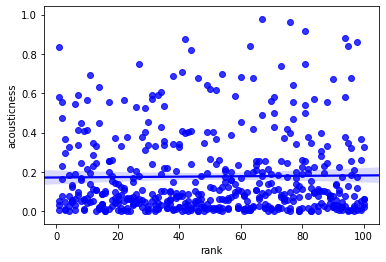

In [56]:
ax = sns.regplot(x='rank', y='acousticness', data=df[['acousticness', 'rank']].astype(float).copy(), color='blue')

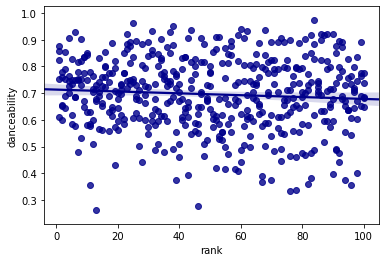

In [44]:
ax = sns.regplot(x = 'rank', y = 'danceability', data=df[['danceability', 'rank']].astype(float).copy(),color = 'darkblue')

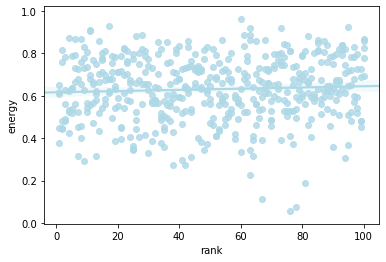

In [47]:
sns.regplot(x = 'rank', y = 'energy', data =df[['energy', 'rank']].astype(float).copy(), color = 'lightblue')

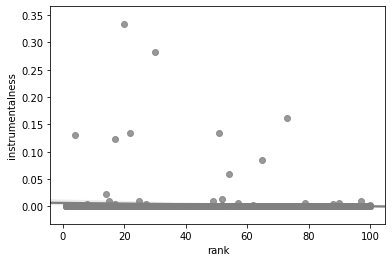

In [50]:
sns.regplot(x = 'rank', y = 'instrumentalness', data=df[['instrumentalness', 'rank']].astype(float).copy(), color = 'grey')

Instrumentalness is a measure of whether a song has lyrics. The number should tend to either 0 or 1, with the continuous nature being the confidence level of assigning the instrumental attribute. Anything below than .5 is determined to be a song with lyrics, so it degenerates to a binary condition. All of the songs in this dataset are "vocal".

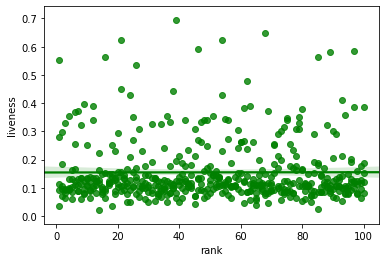

In [51]:
sns.regplot(x = 'rank', y = 'liveness', data =df[['liveness', 'rank']].astype(float).copy(), color = 'green')

None of the values for liveness are above 0.8. This means there is not a likely chance any of them are live. This will not be factored into the end result.

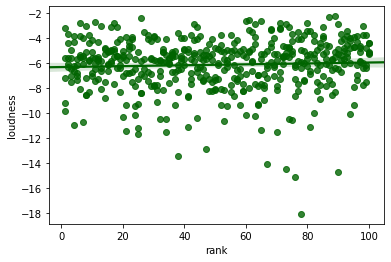

In [52]:
sns.regplot(x = 'rank', y = 'loudness', data = df[['loudness', 'rank']].astype(float).copy(), color = 'darkgreen')

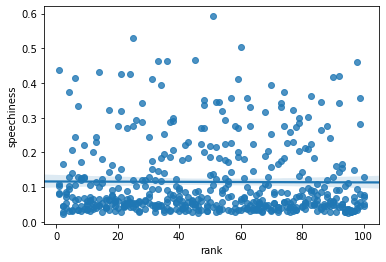

In [53]:
sns.regplot(x = 'rank', y = 'speechiness', data =df[['speechiness', 'rank']].astype(float).copy())

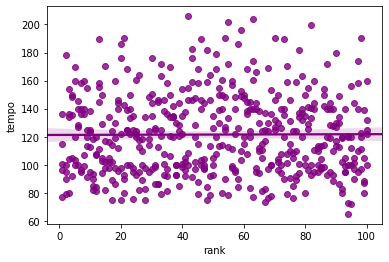

In [55]:
sns.regplot(x = 'rank', y = 'tempo', data =df[['tempo', 'rank']].astype(float).copy(),color = 'purple')

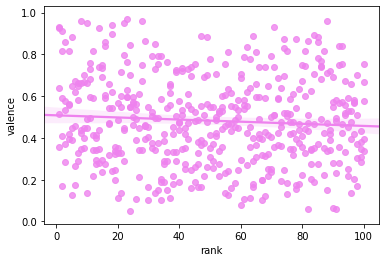

In [54]:
sns.regplot(x = 'rank', y = 'valence', data =df[['valence', 'rank']].astype(float).copy(), color = 'violet')

## Plotting features based on year
<p>We can also use the <code>catplot</code> function in Seaborn to divide the scatterplots up based on year to see if there are any yearly trends to pick up on. One again, there does not seem to be any distinguishable difference between the graphs. This is actually a good thing here when examining the features across years, because we do not want the composition of features that make a popular song to change much, if at all, over the years. It is unrealistic to expect the same song features in 2010 that made it hit number 1 on the charts to cause it to hit number 1 in 2019 since musical tastes change. For this reason, it is a positive insight to our data that musical tastes have not drastically changed over the past few years.</p>

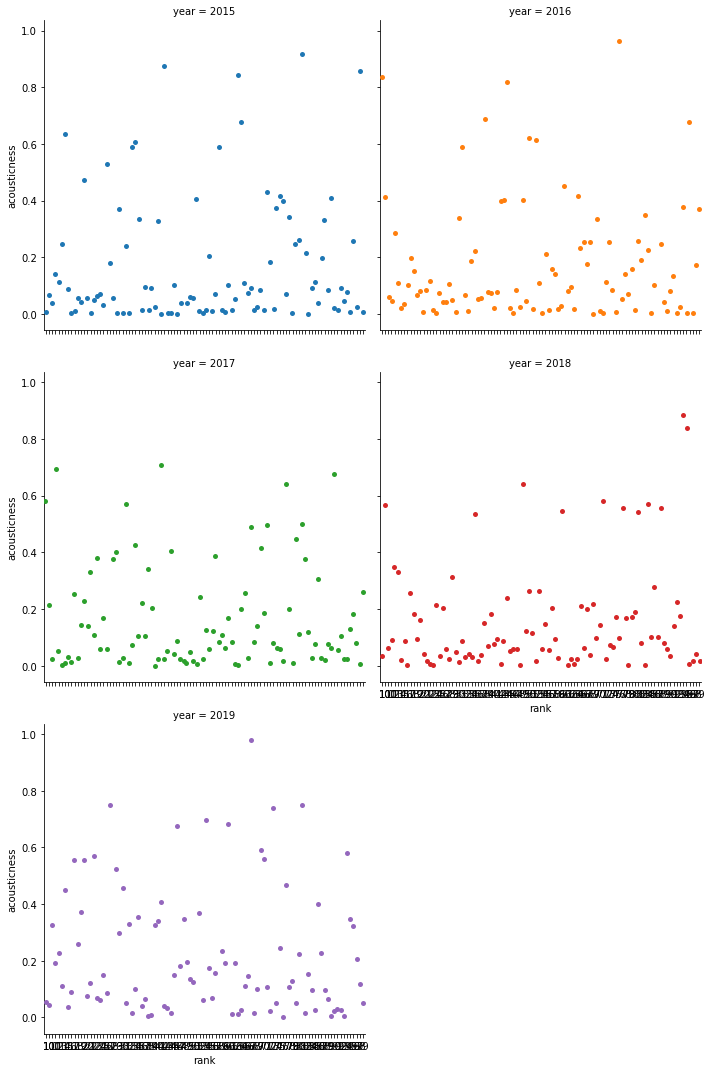

In [28]:
sns.catplot(x = 'rank', y = 'acousticness', col = 'year', data = df, col_wrap = 2, hue = 'year')

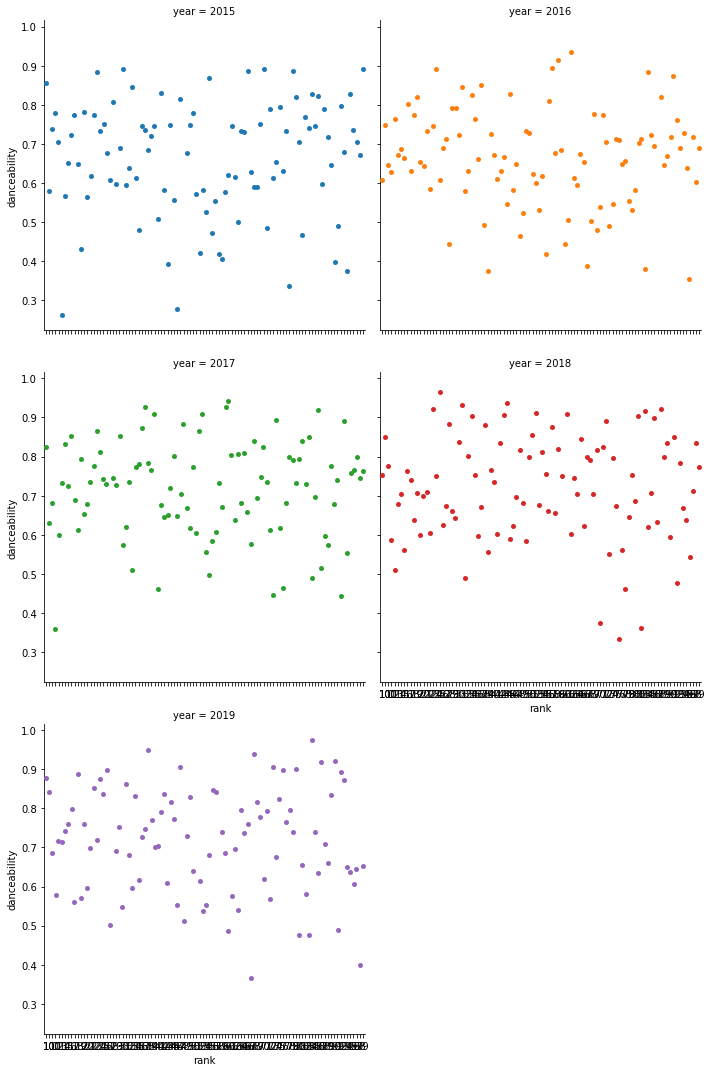

In [29]:
sns.catplot(x = 'rank', y = 'danceability', col = 'year', data = df, col_wrap = 2, hue = 'year')

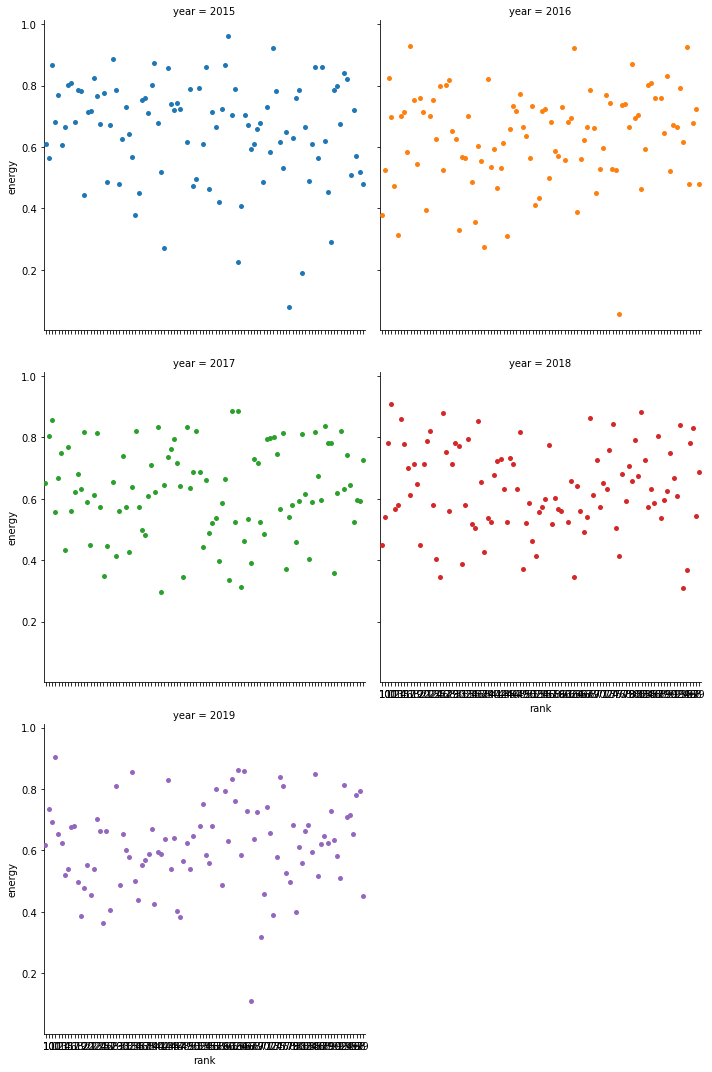

In [30]:
sns.catplot(x = 'rank', y = 'energy', col = 'year', data = df, col_wrap = 2, hue = 'year')

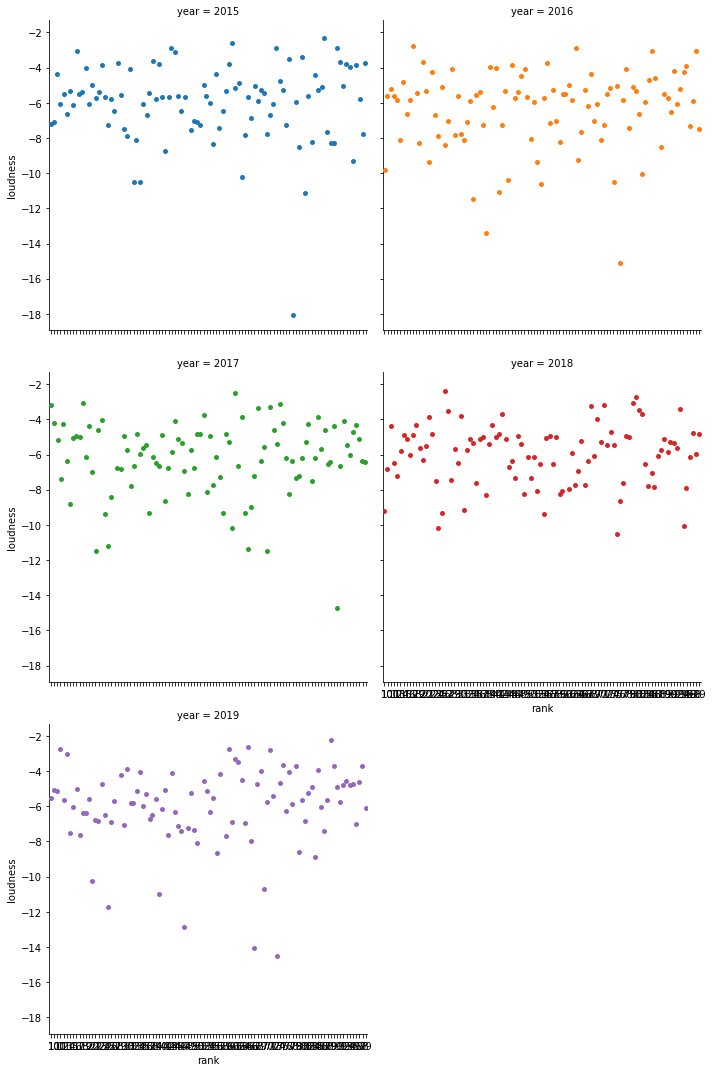

In [31]:
sns.catplot(x = 'rank', y = 'loudness', col = 'year', data = df, col_wrap = 2, hue = 'year')

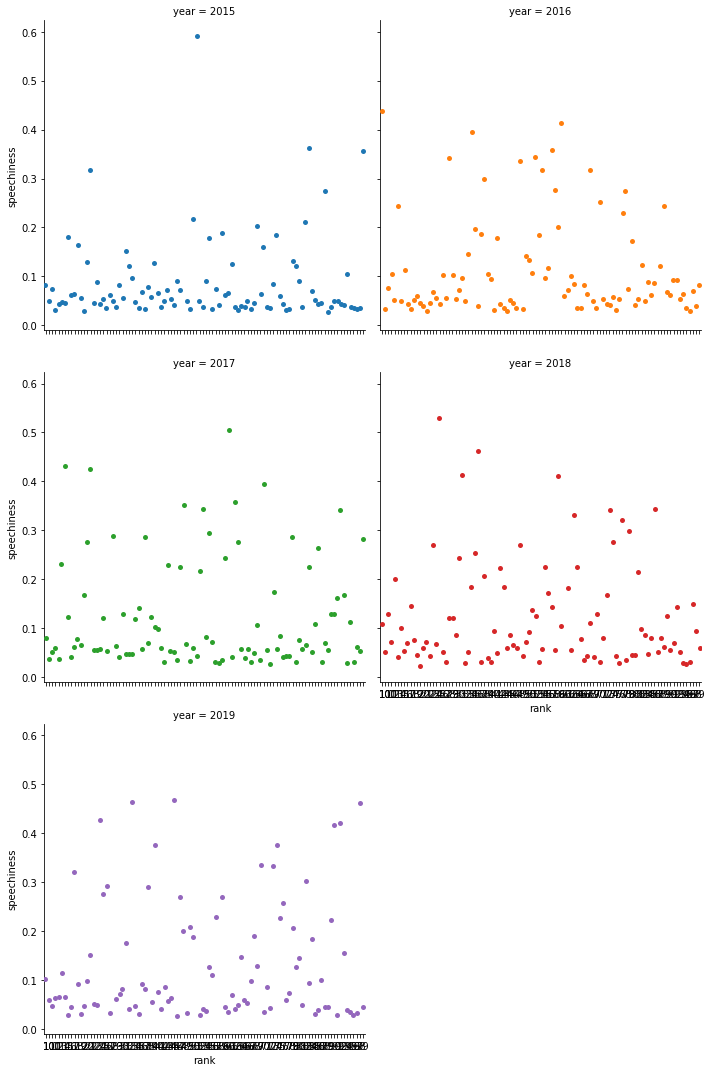

In [32]:
sns.catplot(x = 'rank', y = 'speechiness', col = 'year', data = df, col_wrap = 2, hue = 'year')

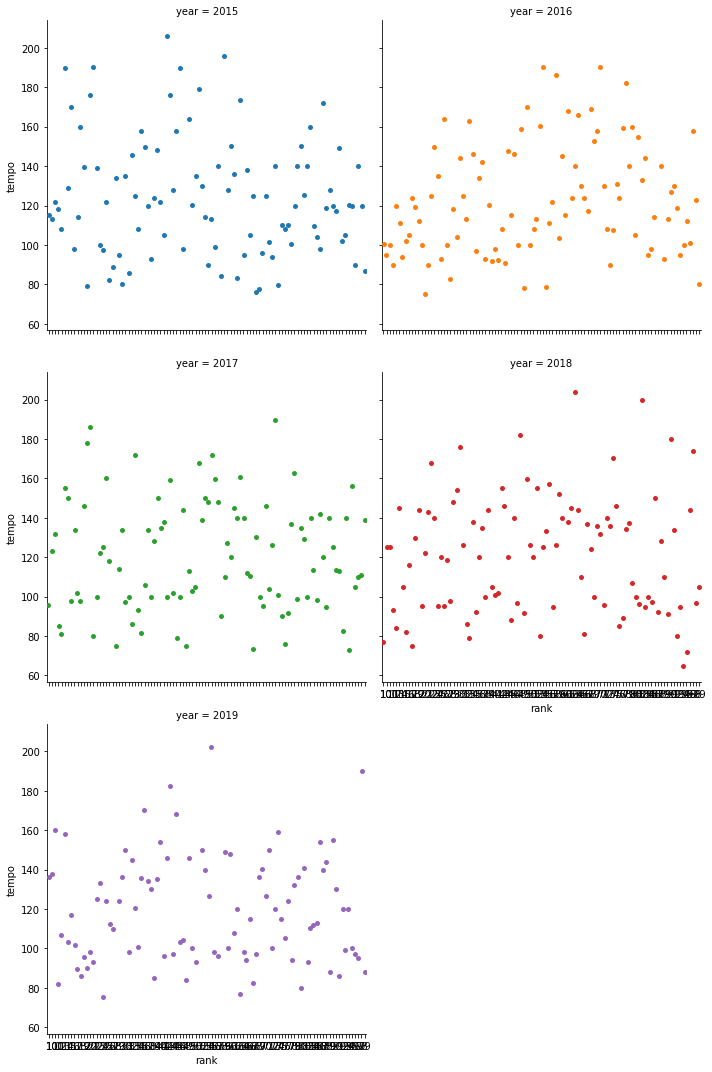

In [33]:
sns.catplot(x = 'rank', y = 'tempo', col = 'year', data = df, col_wrap = 2, hue = 'year')

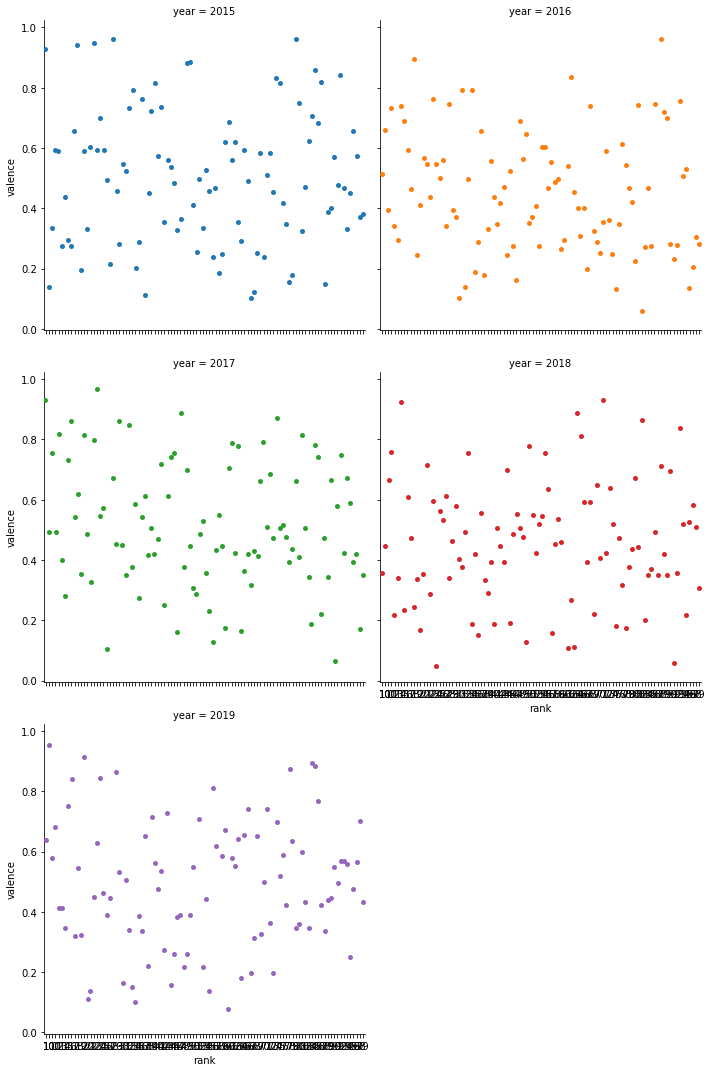

In [34]:
sns.catplot(x = 'rank', y = 'valence', col = 'year', data = df, col_wrap = 2, hue = 'year')

## Plotting Average Values

<p>The below code extracts and calculates the average value for each feature we will be considering in our machine learning model. Some averages for the features seem to show a very very slight correlation, which seems to be in line with the visualization results that we found when plotting all of the data points over the years. After this step of visualization, we will begin our machine learning model and try to predict song ranks.</p>

In [57]:
avg_acou = []
avg_danc = []
avg_nrgy = []
avg_loud = []
avg_spch = []
avg_temp = []
avg_vale = []
rank = [i for i in range(1,101)]

for i in range(1,101):
    subset = df.query('rank =="' + str(i) + '"')
    avg_acou.append(subset['acousticness'].mean())
    avg_danc.append(subset['danceability'].mean())
    avg_nrgy.append(subset['energy'].mean())
    avg_loud.append(subset['loudness'].mean())
    avg_spch.append(subset['speechiness'].mean())
    avg_temp.append(subset['tempo'].mean())
    avg_vale.append(subset['valence'].mean())

avgs = pd.DataFrame([pd.Series(rank),pd.Series(avg_acou),pd.Series(avg_danc),pd.Series(avg_nrgy)\
                    , pd.Series(avg_loud),pd.Series(avg_spch),pd.Series(avg_temp),pd.Series(avg_vale)])

avgs = avgs.transpose()

In [58]:
avgs.columns = ['rank', 'avg acousticness','avg danceability', 'avg energy', 'avg loudness', \
              'avg speechiness','avg tempo', 'avg valence']

avgs

,rank,avg acousticness,avg danceability,avg energy,avg loudness,avg speechiness,avg tempo,avg valence
0,1.0,0.302102,0.78440,0.54140,-7.00100,0.162320,104.91860,0.67400
1,2.0,0.300140,0.68940,0.58960,-5.19380,0.062260,108.39800,0.57960
2,3.0,0.146752,0.74580,0.58740,-6.31620,0.066360,121.63660,0.52500
3,4.0,0.122376,0.76900,0.59520,-6.39540,0.145920,126.03520,0.55040
4,5.0,0.083020,0.70260,0.62380,-6.59920,0.097060,130.56660,0.49900
5,6.0,0.166842,0.72540,0.72280,-5.09260,0.174020,128.08680,0.43800
6,7.0,0.305200,0.71500,0.53920,-6.36900,0.119220,125.01620,0.50200
7,8.0,0.214600,0.74780,0.62860,-6.49920,0.099000,128.34900,0.56560
8,9.0,0.108966,0.75220,0.65180,-5.58320,0.115900,120.77220,0.51240
9,10.0,0.261360,0.73020,0.63360,-5.74740,0.045640,118.81180,0.53820


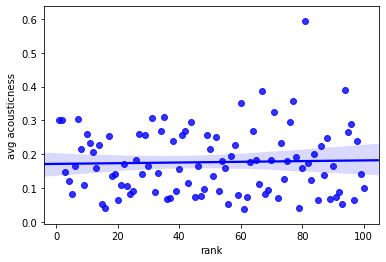

In [60]:
sns.regplot(x='rank',y='avg acousticness', data = avgs, color = 'blue')

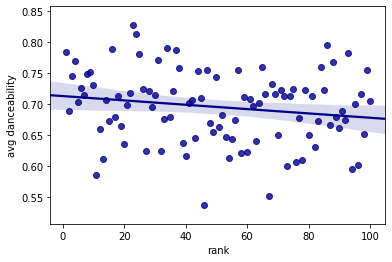

In [61]:
sns.regplot(x='rank',y='avg danceability', data = avgs, color = 'darkblue')

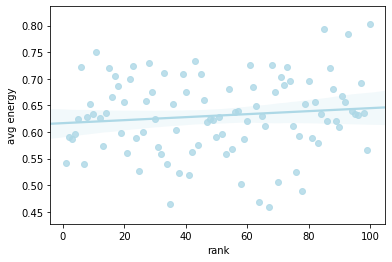

In [62]:
sns.regplot(x='rank',y='avg energy', data = avgs, color = 'lightblue')

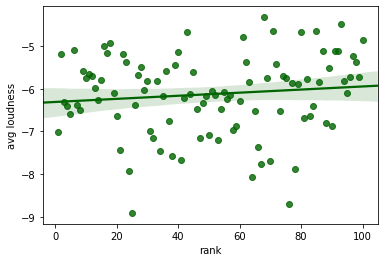

In [63]:
sns.regplot(x='rank',y='avg loudness', data = avgs, color = 'darkgreen')

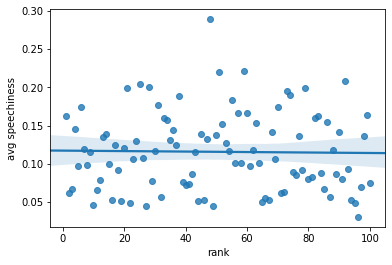

In [64]:
sns.regplot(x='rank',y='avg speechiness', data = avgs)

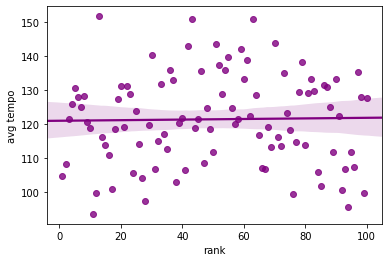

In [65]:
sns.regplot(x='rank',y='avg tempo', data = avgs, color = 'purple')

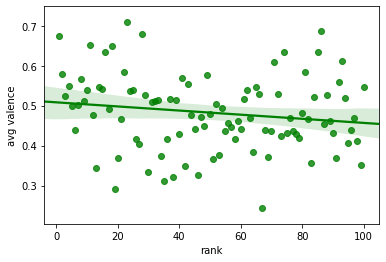

In [66]:
sns.regplot(x='rank',y='avg valence', data = avgs, color = 'green')

## Linear Model

This model predicts that a song's rank will be determined by the following equation:
<p><math> rank = (7.6783 * ac) - (8.0450 * da) + (17.9542 * en) + (0.3824 * lo) + (5.4986 * sp) - (0.0016 * tm) - (13.2825 * va) + 51.7219 </math></p>
<p>Some interesting and startling conclusions are that the largest influencing factors on popularity of a song according to our model are energy and valence. Valence, which describes positivity and happiness, actually had the largest negative impact on a song's popularity. Tempo also appears to have very little impact at all on the outcome of a song's ranking.</p>

<p>A very disappointing insight from this machine learning model is that the R<sup>2</sup> score of our model which represents the percentage of explained variance of the predictions is 0.0167108. This is an extremely low number, and means that our model is not accurate in the slightest in predicting song rankings.</p>

<b>NOTE:</b> Our predictions came back as values in a range from 43-54. These predictions were interpreted as the minimum value being considered as rank 1, and the maximum value being considered as rank 15.

In [88]:
target = pd.DataFrame(df['rank'], columns=['rank'])
X = df[df['year'] != 2019]
X = df[['acousticness','danceability','energy', 'loudness','speechiness','tempo', 'valence']]
y = target["rank"]

# Extract 2019 data and get top 15 songs of 2019
testData = df[df['year'] == 2019][:-82]
testData = testData[['acousticness','danceability','energy', 'loudness','speechiness','tempo', 'valence']]

# Fit the model with training data, and predict using the top 15 songs of 2019
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(testData)

print("Predictions: " + str(predictions))
print("Coefficients: " + str(lm.coef_))
print("Intercept: " + str(lm.intercept_))
print("R^2 Score: " + str(lm.score(X, y)))

Predictions: [45.90946476 44.32988445 47.10722805 46.41779926 48.78912502 52.00506864
 48.86346011 44.64557124 51.7853027  43.97370705 54.89522847 51.99877828
 51.7529908  51.26472952 43.29341403]
Coefficients: [ 7.67825524e+00 -8.04499659e+00  1.79542897e+01  3.82431025e-01
  5.49855755e+00 -1.60898004e-03 -1.32824686e+01]
Intercept: 51.721863713409455
R^2 Score: 0.016710800446899654


<h1>Conclusion</h1>

<p>Music is one of the biggest elements of culture in todays world, and it would have been extremely insightful to see if there was some way that the popularity of a song could be predicted by its musical components. Through our project, we were not able to accurately find a correlation between the features of a song that we could query from Spotify's API and the overall ranking of a song from the <i>Billboard</i> Hot 100 list over the years. This result was expected, because there are so many factors that go into making a popular song outside of the actual song itself. Perhaps with more data collection outside song features and a more advanced machine learning model, such as a neural network, that model would be able to more accurately predict song popularity. That level of work required in crafting such a model is outside the scope of this class, but would be interesting to see if it was able to accurately make predictions as to how popular a song will become in today's day and age. Thanks for reading!

In [89]:
!jupyter nbconvert --to html final_v2.ipynb

[NbConvertApp] Converting notebook final_v2.ipynb to html
[NbConvertApp] Writing 1135582 bytes to final_v2.html
